## Keep River example


In [1]:
%pylab notebook
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
from IPython.display import display
import ipywidgets as widgets
import datetime as dt
import matplotlib as mpl


Populating the interactive namespace from numpy and matplotlib


In [2]:
dc = datacube.Datacube(app='Keep River Example')

In [3]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords


#Define temporal range
start_of_epoch = '1987-01-01'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest
sensors = ['ls8', 'ls7', 'ls5'] 

query = {'time': (start_of_epoch, end_of_epoch)}
lat_max = -15.79
lat_min = -15.86
lon_max = 129.18
lon_min = 129.07

query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [4]:
print query

{'y': (-15.79, -15.86), 'x': (129.07, 129.18), 'crs': 'EPSG:4326', 'time': ('1987-01-01', '2016-12-31')}


# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [5]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [6]:
#Retrieve the NBAR and PQ data for sensor n
sensor_clean = {}
for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day',  **query)
    #grab the projection info before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    #This line is to make sure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    #Apply the PQ masks to the NBAR
    cloud_free = masking.make_mask(sensor_pq, **mask_components)
    good_data = cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar = sensor_nbar.where(good_data)
    sensor_clean[sensor] = sensor_nbar

In [7]:
#Conctanate measurements from the different sensors together
nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine
#calculate the normalised difference vegetation index  (NDVI)
all_ndvi_sorted = ((nbar_clean.nir - nbar_clean.red)/(nbar_clean.nir + nbar_clean.red))

In [8]:
print 'The number of time slices at this location is '+ str(nbar_clean.red.shape[0]) 

The number of time slices at this location is 1187


## Plotting an image, select a location for extracting the hovmoller plot
The interactive widget allows you to select a location (x, y coordinates), the plot will then show all of the time series that fall into the same x coordinate.

In [9]:
#select time slice of interest - this is trial and error until you get a decent image
time_slice_i = 1180
rgb = nbar_clean.isel(time =time_slice_i).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
#rgb = nbar_clean.isel(time =time_slice).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 4500
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

<IPython.core.display.Javascript object>


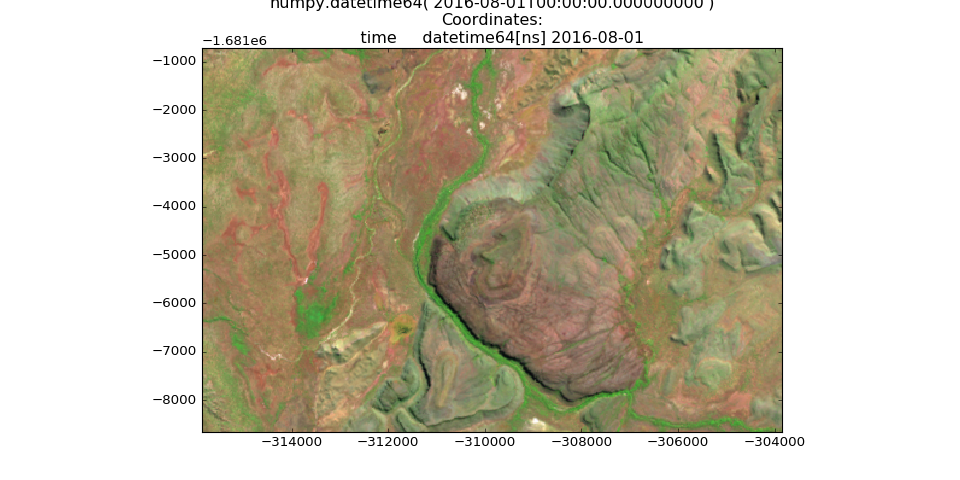

In [10]:
#Click on this image to chose the location for time series extraction
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(12,6))
plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])

fig.canvas.mpl_connect('button_press_event', callback)
date_ = nbar_clean.time[time_slice_i]
plt.title(date_.astype('datetime64[D]'))
plt.show()
display(w)

In [26]:
#If you know the exact coordinates of your sampling point in Albers Equal Area coordinates you can pass those coordinates 
#here as the arguments x, and y 
#x = your x coord here
#y = your y coord here

#this converts the map x coordinate into image x coordinates
image_coords = ~affine * (x, y)
imagex = int(image_coords[0])
imagey = int(image_coords[1])

#extract the NDVI time series for the location that was clicked
ts = all_ndvi_sorted.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any')

<IPython.core.display.Javascript object>


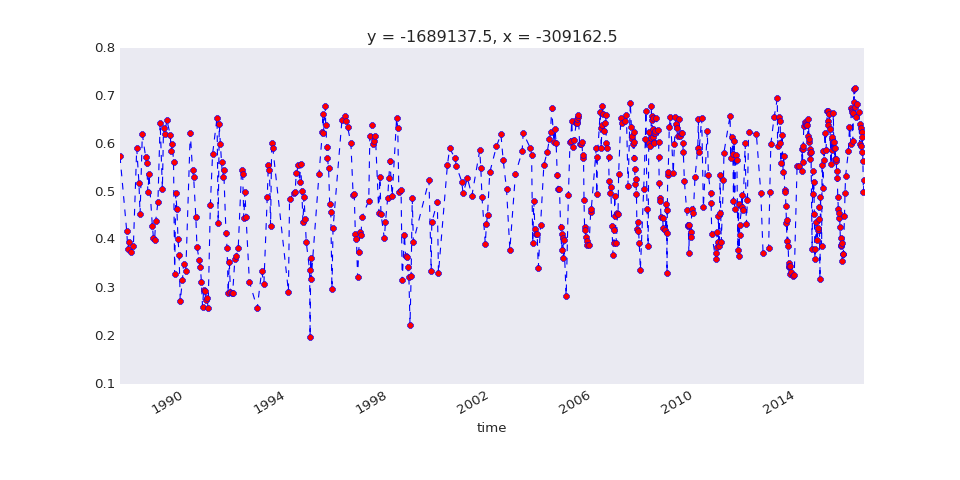

In [25]:
fig = plt.figure(figsize =(12,6))
ts.plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='r')
firstyear = '2000-01-01'
lastyear = '2016-12-31'
#use the plt.axis line below to control the max and min values for time and NDVI value
#plt.axis([firstyear , lastyear ,0, 0.6])

### The plot below stacks the NDVI curve for each year to create a phenology plot

<IPython.core.display.Javascript object>


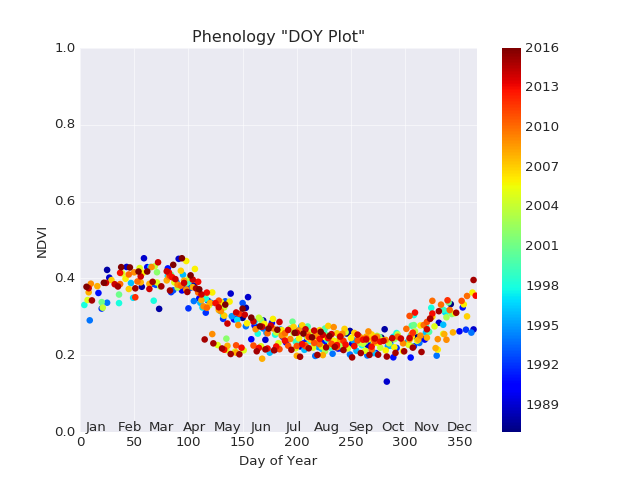

In [23]:
mpl.style.use('seaborn-dark')

#MEASUREMENT = 'nir'

# Given ``data`` is an xarray.Dataset with dimensions ('time', 'y', 'x')
pix = ts

fig, ax = plt.subplots()

# Grabbing the day of year (for xaxis) and year (for color) made easier with xarray
sp = ax.scatter(pix['time.dayofyear'], pix, c=pix['time.year'],
                cmap=mpl.cm.jet, marker='o', edgecolor='none', s=35)
fig.colorbar(sp)

# If you want the months to show up as minor ticks...
month_doys = [dt.date(2000, m, 15).timetuple().tm_yday for m in range(1, 13)]
months = mpl.ticker.FixedLocator(month_doys)
months_fmrt = mpl.dates.DateFormatter('%b')

ax.xaxis.set_ticks(month_doys, minor=True)
ax.tick_params(axis='x', which='minor', direction='in', pad=-10)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmrt)

# Labels and axis limits are good
ax.grid(True)
ax.set_xlim((0, 366))
ax.set_ylim((0, 1))
ax.set_xlabel('Day of Year')
ax.set_ylabel('NDVI')
ax.set_title('Phenology "DOY Plot"')